# Generate Gray Phone Challenge Paper Data
Spring 2021

In [109]:
library(gmodels) ## for CrossTable
library(stringr)
library(ggplot2)
library(repr)
library(lme4)
library(lmerTest)
library(lubridate)
source("ATE.boot.R")

In [110]:
## Bootstrap Settings
alpha <- .05   # Signifiant level
B <- sims <- 5000      # Number of sim

cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

In [111]:
#gpc.df$Turning.my.phone.gray.will...
#gpc.df[str_detect(gpc.df$Turning.my.phone.gray.will...,"INCREASE"),]

In [112]:
gpc.df <- read.csv("~/Tresors/Gray Phone Challenge/pilot.results.10.2018/gpc_merged_observations_surveys_03.2019/gpc_merged_observations_surveys_03.2019.csv")

gpc.df$colorblindness <- gpc.df$Have.you.ever.been.diagnosed.with.colorblindness. !="Never been diagnosed with color blindness" 
gpc.df$daily.work <- 0
gpc.df[str_detect(gpc.df$Do.you.use.this.phone.for.work.,"daily work"),]$daily.work <- 1
gpc.df[str_detect(gpc.df$Do.you.use.this.phone.for.work.,"work calls"),]$daily.work <- 1

gpc.df$daily.do.not.disturb <- 0
gpc.df[str_detect(gpc.df$How.often.do.you.use.the..Do.Not.Disturb..function.,"Almost all"),]$daily.do.not.disturb <- 1
gpc.df[str_detect(gpc.df$How.often.do.you.use.the..Do.Not.Disturb..function.,"once a day"),]$daily.do.not.disturb <- 1

gpc.df$effect.prediction <- 0
gpc.df[str_detect(gpc.df$Turning.my.phone.gray.will...,"DECREASE"),]$effect.prediction <- -1
## no one predicted an increase
#gpc.df[str_detect(gpc.df$Turning.my.phone.gray.will...,"INCREASE"),]$effect.prediction <- 1

gpc.df$weekend <- lubridate::wday(gpc.df$date) %in% c(1,7)

## add one to pickups to avoid division by zero
#gpc.df$seconds.per.unlock <- gpc.df$screen_time*60 / (gpc.df$pickups +1)

gpc.df$treat[gpc.df$randomization == "CONTROL"] <- 0
gpc.df$treat[gpc.df$randomization == "TREATMENT"] <- 1
gpc.df$treat[gpc.df$baseline == 1] <- -1
gpc.df$treat.f <- factor(gpc.df$treat,
                     levels = -1:1,
                     labels = c("baseline", "full-color", "grayscale"))

## Summarize Participants

In [113]:
participants.df <- gpc.df[!duplicated(gpc.df$user_id),]

In [114]:
summary(participants.df$colorblindness)

   Mode   FALSE    TRUE 
logical       8       6 

In [115]:
print("Use for work")
summary(factor(participants.df$daily.work))

print("Use Do not Disturb Daily")
summary(factor(participants.df$daily.do.not.disturb))

[1] "Use for work"


0  1 
 2 12

[1] "Use Do not Disturb Daily"


0 1 
8 6

In [116]:
colnames(gpc.df)

[1] "X"                                                                        
 [2] "X.1"                                                                      
 [3] "baseline"                                                                 
 [4] "compliance"                                                               
 [5] "date"                                                                     
 [6] "include"                                                                  
 [7] "naive_randomization_block"                                                
 [8] "pickups"                                                                  
 [9] "randomization"                                                            
[10] "screen_time"                                                              
[11] "user_id"                                                                  
[12] "At.what.time.of.the.day.would.you.like.to.receive.notifications."         
[13] "What.is.your.Timezone."                                                   
[14] "What.is.the.model.of.your.phone."                                         
[15] "How.many.smartphones.do.you.have."                                        
[16] "How.many.tablets.do.you.have."                                            
[17] "Are.you.using.your.main.phone.for.this.gray.phone.challenge."             
[18] "Do.you.use.this.phone.for.work."                                          
[19] "What.is.your.phone.s.current.auto.lock.setting."                          
[20] "How.often.do.you.use.the..Do.Not.Disturb..function."                      
[21] "On.average..how.many.minutes.do.you.spend.on.your.phone.each.day.."       
[22] "On.average..how.often.do.you.check.your.smartphone..Once.every.__.minutes"
[23] "How.much.time.do.you.use.your.smartphone.for.the.following.activities."   
[24] "Where.do.you.normally.keep.your.mobile.phone...Check.all.that.apply."     
[25] "Do.you.subscribe.to.a.monthly.mobile.phone.plan."                         
[26] "How.much.mobile.data.is.included.in.your.monthly.mobile.phone.plan."      
[27] "How.do.you.access.the.Internet.on.your.phone."                            
[28] "ishihara_12"                                                              
[29] "ishihara_8"                                                               
[30] "ishihara_29"                                                              
[31] "ishihara_NA"                                                              
[32] "Have.you.ever.been.diagnosed.with.colorblindness."                        
[33] "What.is.your.year.of.birth."                                              
[34] "What.is.the.highest.degree.or.level.of.school.you.have.completed."        
[35] "Employment.status..Are.you.currently....."                                
[36] "If.you.are.employed..how.many.jobs.do.you.have."                          
[37] "Turning.my.phone.gray.will..."                                            
[38] "How.confident.are.you.about.the.effect.you.predict."                      
[39] "How.commonly.will.others.experience.the.same.effect.as.you."              
[40] "Tell.us.more.about.why.you.re.participating..optional."                   
[41] "rg_colorblind"                                                            
[42] "colorblindness"                                                           
[43] "daily.work"                                                               
[44] "daily.do.not.disturb"                                                     
[45] "effect.prediction"                                                        
[46] "weekend"                                                                  
[47] "treat"                                                                    
[48] "treat.f"

In [117]:
participant.baseline.df <- aggregate(subset(gpc.df, baseline==1), by=list(subset(gpc.df, baseline==1)$user_id), FUN=mean, na.rm=TRUE)

Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.defaul

Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.defaul

Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.defaul

Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.defaul

Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.defaul

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



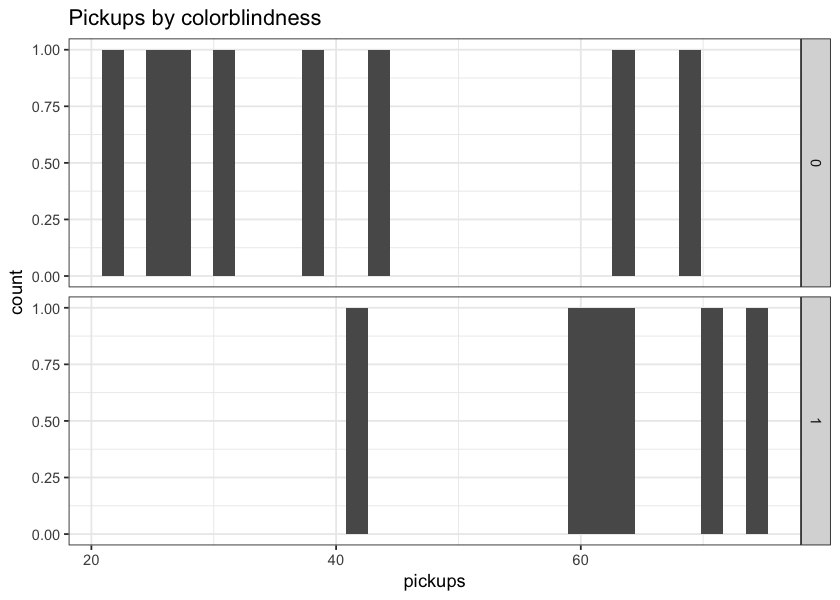

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



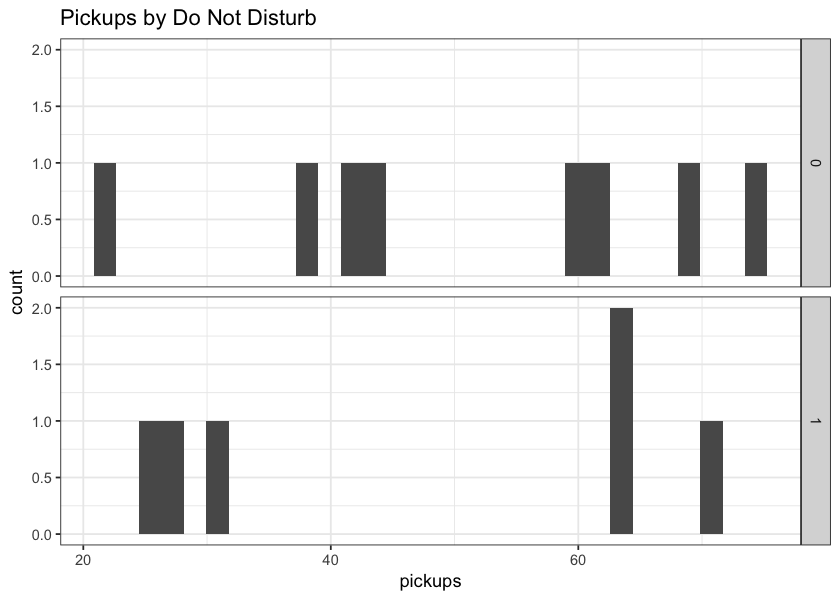

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



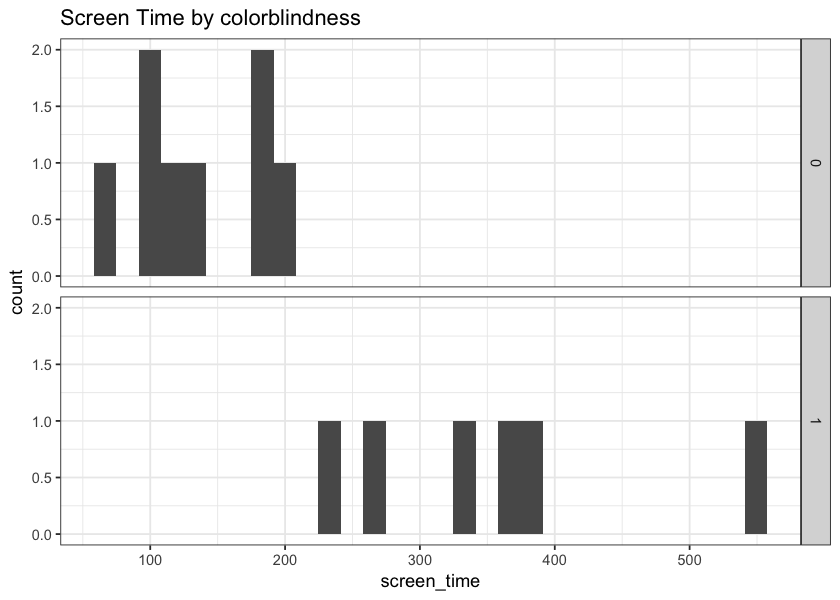

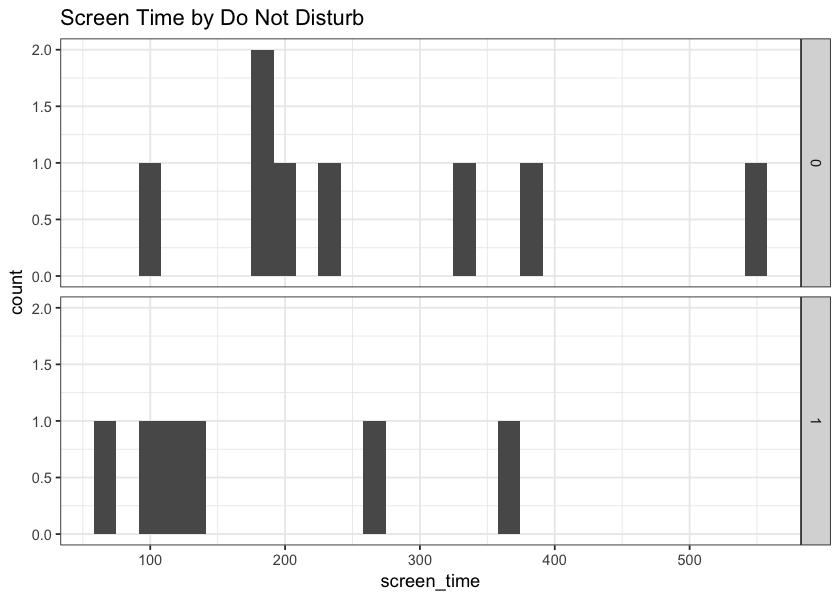

In [118]:
ggplot(participant.baseline.df, aes(pickups)) +
    geom_histogram() +
    facet_grid(colorblindness ~ .) +
    ggtitle("Pickups by colorblindness") +
    theme_bw()


ggplot(participant.baseline.df, aes(pickups)) +
    geom_histogram() +
    facet_grid(daily.do.not.disturb ~ .) +
    ggtitle("Pickups by Do Not Disturb") +
    theme_bw()


ggplot(participant.baseline.df, aes(screen_time)) +
    geom_histogram() +
    facet_grid(colorblindness ~ .) +
    ggtitle("Screen Time by colorblindness") +
    theme_bw()

ggplot(participant.baseline.df, aes(screen_time)) +
    geom_histogram() +
    facet_grid(daily.do.not.disturb ~ .) +
    ggtitle("Screen Time by Do Not Disturb") +
    theme_bw()


# ggplot(participant.baseline.df, aes(seconds.per.unlock)) +
#     geom_histogram() +
#     facet_grid(colorblindness ~ .) +
#     ggtitle("Seconds per unlock by colorblindness") +
#     theme_bw()

# ggplot(participant.baseline.df, aes(seconds.per.unlock)) +
#     geom_histogram() +
#     facet_grid(daily.do.not.disturb ~ .) +
#     ggtitle("Seconds per unlock by Do Not Disturb") +
#     theme_bw()


In [119]:
summary(pickups.m1 <- lm(pickups ~ colorblindness + daily.do.not.disturb + daily.work, data=participant.baseline.df))


Call:
lm(formula = pickups ~ colorblindness + daily.do.not.disturb + 
    daily.work, data = participant.baseline.df)

Residuals:
    Min      1Q  Median      3Q     Max 
-20.294 -11.286  -1.126   8.171  28.128 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)           39.9569    13.8636   2.882   0.0163 *
colorblindness        21.9940     9.2550   2.376   0.0388 *
daily.do.not.disturb  -0.4793     9.2550  -0.052   0.9597  
daily.work             0.2006    12.9279   0.016   0.9879  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.86 on 10 degrees of freedom
Multiple R-squared:  0.3702,	Adjusted R-squared:  0.1813 
F-statistic: 1.959 on 3 and 10 DF,  p-value: 0.1841


In [120]:
colorblind.pickup.diff <- coef(summary(pickups.m1))['colorblindness',]['Estimate']
colorblind.pickup.pvalue <- coef(summary(pickups.m1))['colorblindness',]['Pr(>|t|)']

In [121]:
summary(pickups.m1 <- lm(screen_time ~ colorblindness + daily.do.not.disturb + daily.work, data=participant.baseline.df))


Call:
lm(formula = screen_time ~ colorblindness + daily.do.not.disturb + 
    daily.work, data = participant.baseline.df)

Residuals:
     Min       1Q   Median       3Q      Max 
-145.127  -37.572    4.341   25.847  173.051 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            153.99      66.71   2.309 0.043613 *  
colorblindness         212.37      44.53   4.769 0.000758 ***
daily.do.not.disturb   -60.93      44.53  -1.368 0.201199    
daily.work              11.02      62.20   0.177 0.862971    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 81.1 on 10 degrees of freedom
Multiple R-squared:  0.7344,	Adjusted R-squared:  0.6547 
F-statistic: 9.217 on 3 and 10 DF,  p-value: 0.003157


In [122]:
participant.baseline.sd.df <- aggregate(subset(gpc.df, baseline==1), by=list(subset(gpc.df, baseline==1)$user_id), FUN=sd, na.rm=TRUE)

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector.”
Warning message in var(if (i

In [123]:
#gpc.df$user_id

# Estmate Compliance

In [124]:
full.procedure.count = 28
compliance.df <- aggregate(subset(gpc.df, treat!=-1)[c("include")], by=list(subset(gpc.df, treat!=-1)$user_id), FUN=sum)
compliance.df$noncompliance.count <- full.procedure.count - compliance.df$include
compliance.df$compliance.pct <- compliance.df$include/ full.procedure.count *100
print(paste(prettyNum(nrow(subset(compliance.df, compliance.pct>80)) / nrow(compliance.df)*100, digits=2),
            "% completed at least 80% study actions", sep=""))
compliance.df

[1] "79% completed at least 80% study actions"


Group.1,include,noncompliance.count,compliance.pct
35,24,4,85.71429
36,26,2,92.85714
46,28,0,100.00000
47,24,4,85.71429
52,28,0,100.00000
53,28,0,100.00000
55,26,2,92.85714
56,26,2,92.85714
57,28,0,100.00000
58,23,5,82.14286


# Compute and Pool Results for Participants

In [125]:
bootstrap.results <- function(df, userid){
    eligible.days <- subset(df, user_id == userid & include==1)
    boot.df <- ATE.boot(data = subset(eligible.days, eligible.days$treat.f != "baseline"),
                                    outcome = "screen_time",
                                    treatment = "treat.f", control = "full-color",
                                    boot = B, conf.level = 1 - alpha)

    result.df <- boot.df$test
    result.df$user_id <- eligible.days[1,]$user_id
    result.df$colorblindness <- eligible.days[1,]$colorblindness
    result.df$daily.work <- eligible.days[1,]$daily.work
    result.df$daily.do.not.disturb <- eligible.days[1,]$daily.do.not.disturb
    return(result.df)
    
}

In [126]:
user.ids <- unique(gpc.df$user_id)
screen.time.df <- bootstrap.results(gpc.df,  user.ids[1])
for(i in seq(2,length(user.ids))){
     screen.time.df <- rbind(bootstrap.results(gpc.df,  user.ids[i]), screen.time.df)
}
# screen.time.df

## Illustrate Results

In [127]:
#with(screen.time.df, reorder(effect.range))
screen.time.df$user <- factor(screen.time.df$user_id)
screen.time.df$effect.range <- screen.time.df$conf.high - screen.time.df$conf.low
screen.time.df$user <- with(screen.time.df, reorder(user, diff, min))


In [128]:
diagnose.labs <- c("Colorblindness\nNot Diagnosed", "Colorblindness\nDiagnosed")
names(diagnose.labs) <- c(FALSE, TRUE)

In [129]:
floor(min(screen.time.df$conf.low)/30)*30
ceiling(max(screen.time.df$conf.high)/30)*30

[1] -210

[1] 150

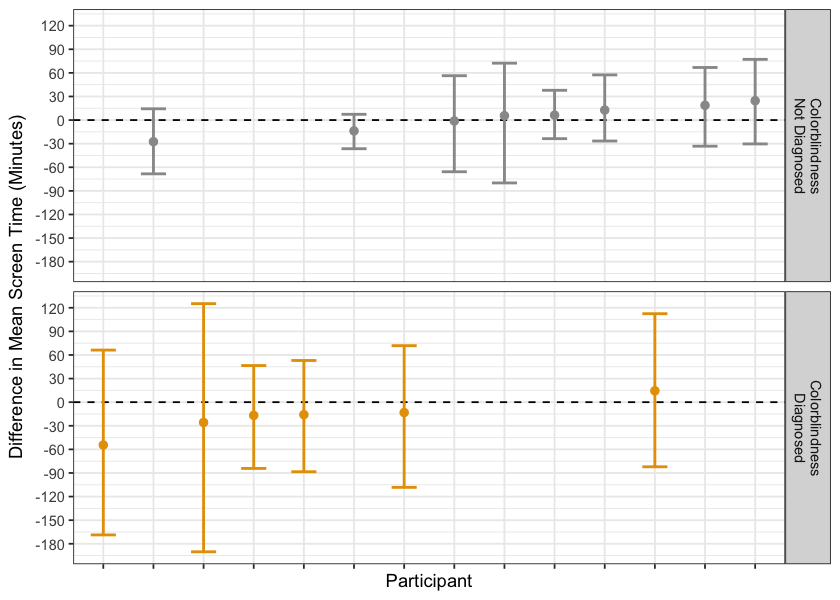

In [130]:
#screen.time.df$user <- with(screen.time.df, reorder(user, effect.range, mean))
options(repr.plot.width=7, repr.plot.height=5)



ggplot(screen.time.df, aes(user, diff, color=colorblindness)) +
    geom_hline(yintercept=0, linetype="dashed") +
    geom_errorbar(aes(ymin=screen.time.df$conf.low, 
                    ymax=screen.time.df$conf.high), size=0.8, width=0.5) +
    geom_point(size=2) +
    scale_color_manual(values=cbPalette, guide=FALSE) +
    scale_y_continuous(breaks=(seq(floor(min(screen.time.df$conf.low)/30)*30,
                                   ceiling(max(screen.time.df$conf.high)/30)*30,
                                  30))) +
    
    facet_grid(colorblindness ~ . , labeller = labeller(colorblindness=diagnose.labs)) +
    theme_bw() +
    theme(axis.text.x = element_blank()) +
    ylab("Difference in Mean Screen Time (Minutes)") +
    xlab("Participant") +
    ggsave("../figures/trial.results.pdf", width=7, height=4)

In [131]:
#screen.time.df

# Correlation Between Expectations and Difference in Means

In [132]:
participant.result.df <- merge(screen.time.df, participants.df, by=c("user_id"))

prediction.test <- cor.test(participant.result.df$effect.prediction, participant.result.df$diff)
prediction.test
prediction.test$p.value


	Pearson's product-moment correlation

data:  participant.result.df$effect.prediction and participant.result.df$diff
t = -0.30335, df = 12, p-value = 0.7668
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5904841  0.4648603
sample estimates:
        cor 
-0.08723536 


[1] 0.7668191

In [107]:
#summary(lm(diff ~ colorblindness.x + effect.prediction, data=participant.result.df))

In [108]:
ls()

[1] "alpha"                      "ATE.boot"                  
 [3] "B"                          "bootstrap.results"         
 [5] "cbPalette"                  "colorblind.pickup.diff"    
 [7] "colorblind.pickup.pvalue"   "compliance.df"             
 [9] "diagnose.labs"              "full.procedure.count"      
[11] "gpc.df"                     "i"                         
[13] "participant.baseline.df"    "participant.baseline.sd.df"
[15] "participant.result.df"      "participants.df"           
[17] "pickups.m1"                 "power"                     
[19] "prediction.test"            "screen.time.df"            
[21] "sims"                       "user.ids"

# Save File

In [133]:
save.image("paper-data.RData")